In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
import re
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Customer Segmentation 

## Objective:  Identify distinct groups of customers based on transactional data, behavioral, or demographic

### Use Cases: 
- Segmenting high-spending customers, debt-heavy users, or cost-conscious customers.
- Personalized marketing campaigns tailored to specific customer segments.
- Identifying high spending customers for loyalty programs

### Steps:

1. **Data Preprocessing**: Clean and prepare the data.
2. **Feature Selection**: Choose features to segment customers (e.g., total_spending, transaction count, average transaction value).
3. **Normalization**: Standardize or normalize the data for clustering.
4. **Clustering**: Apply K-Means or GMM to segment customers.
5. **Visualization**: Optionally, visualize the clusters.

## Step1 Data Preprocessing : Load and merge users_data and transcations_data

In [2]:
# Load the datasets
users_data_path = './data/users_data.csv'
transactions_data_path = './data/transactions_data.csv'

# Read the CSV files
users_data = pd.read_csv(users_data_path)
transactions_data = pd.read_csv(transactions_data_path)

# Display the first few rows of each dataset to understand the structure
users_data.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


In [3]:
transactions_data.head()

,id,date,client_id,amount,use_chip,merchant_id,merchant_category
0,22326462,2019-01-01 00:02:00,496,$119.35,Chip Transaction,30286,Telecommunication Services
1,22326465,2019-01-01 00:05:00,1129,$100.00,Chip Transaction,27092,Money Transfer
2,22326466,2019-01-01 00:06:00,114,$51.71,Chip Transaction,61195,Service Stations
3,22326467,2019-01-01 00:06:00,641,$105.30,Swipe Transaction,75781,"Grocery Stores, Supermarkets"
4,22326468,2019-01-01 00:10:00,114,$82.00,Chip Transaction,61195,Service Stations


## Step1 Data Preprocessing : Exploratory Data Analysis (EDA) : Pre processing

In [4]:
# Data Cleaning: Remove currency symbols and commas, convert to numeric values

# Users Data Cleaning
users_data['per_capita_income'] = users_data['per_capita_income'].replace('[\$,]', '', regex=True).astype(float)
users_data['yearly_income'] = users_data['yearly_income'].replace('[\$,]', '', regex=True).astype(float)
users_data['total_debt'] = users_data['total_debt'].replace('[\$,]', '', regex=True).astype(float)

# Transactions Data Cleaning
transactions_data['amount'] = transactions_data['amount'].replace('[\$,]', '', regex=True).astype(float)
transactions_data['use_chip'] = transactions_data['use_chip'].map({'Chip Transaction': True, 'Swipe Transaction': False})

# Feature Engineering for Users Data: Add Debt-to-Income Ratio
users_data['debt_to_income_ratio'] = users_data['total_debt'] / users_data['yearly_income']

# Add Date Features for Transactions Data
transactions_data['date'] = pd.to_datetime(transactions_data['date'])
transactions_data['transaction_month'] = transactions_data['date'].dt.month
transactions_data['transaction_year'] = transactions_data['date'].dt.year

# Merge Datasets on User ID and Client ID
merged_data = transactions_data.merge(users_data, left_on='client_id', right_on='id', how='inner')

# Rename 'id' in users_data to 'client_id' for consistency
users_data = users_data.rename(columns={'id': 'client_id'})

# Display cleaned and merged data samples
users_data.head(), transactions_data.head(), merged_data.head()


(   client_id  current_age  retirement_age  birth_year  birth_month  gender  \
 0        825           53              66        1966           11  Female   
 1       1746           53              68        1966           12  Female   
 2       1718           81              67        1938           11  Female   
 3        708           63              63        1957            1  Female   
 4       1164           43              70        1976            9    Male   
 
                     address  latitude  longitude  per_capita_income  \
 0             462 Rose Lane     34.15    -117.76            29278.0   
 1    3606 Federal Boulevard     40.76     -73.74            37891.0   
 2           766 Third Drive     34.02    -117.89            22681.0   
 3          3 Madison Street     40.71     -73.99           163145.0   
 4  9620 Valley Stream Drive     37.76    -122.44            53797.0   
 
    yearly_income  total_debt  credit_score  num_credit_cards  \
 0        59696.0    1276

In [5]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1141312 entries, 0 to 1141311
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   id_x                  1141312 non-null  int64         
 1   date                  1141312 non-null  datetime64[ns]
 2   client_id             1141312 non-null  int64         
 3   amount                1141312 non-null  float64       
 4   use_chip              1004581 non-null  object        
 5   merchant_id           1141312 non-null  int64         
 6   merchant_category     1141312 non-null  object        
 7   transaction_month     1141312 non-null  int32         
 8   transaction_year      1141312 non-null  int32         
 9   id_y                  1141312 non-null  int64         
 10  current_age           1141312 non-null  int64         
 11  retirement_age        1141312 non-null  int64         
 12  birth_year            1141312 non-null  in

## Step1 Data Preprocessing : EDA : Some more Correlation Analysis

In [6]:
# Group by num_credit_cards to calculate spending frequency and average transaction value
spending_analysis = merged_data.groupby('num_credit_cards').agg({
    'id_x': 'count',  # Count of transactions (spending frequency)
    'amount': 'mean'  # Average transaction value
}).rename(columns={'id_x': 'transaction_count', 'amount': 'average_transaction_value'})

spending_analysis.reset_index(inplace=True)

# Display the results
print(spending_analysis)

# Optional: Save the results to a CSV file
spending_analysis.to_csv('spending_analysis.csv', index=False)



   num_credit_cards  transaction_count  average_transaction_value
0                 1              76307                  44.702400
1                 2             145505                  45.722007
2                 3             268271                  41.830991
3                 4             300127                  40.640136
4                 5             189487                  42.185773
5                 6             100949                  43.044082
6                 7              40881                  36.857734
7                 8              17249                  53.545555
8                 9               2536                  42.614901


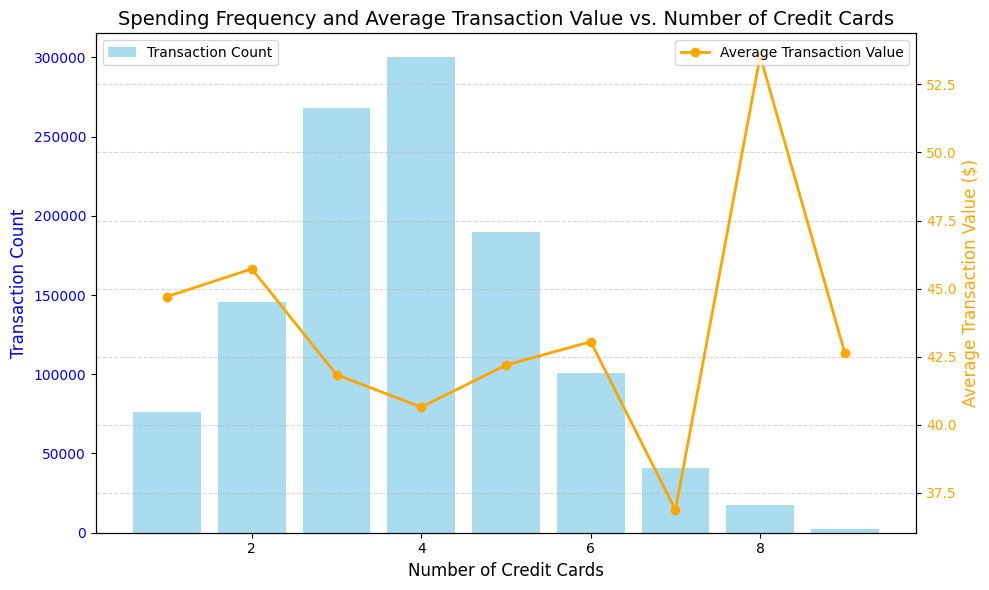

In [7]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for transaction count (spending frequency)
ax1.bar(spending_analysis['num_credit_cards'], spending_analysis['transaction_count'], 
        color='skyblue', label='Transaction Count', alpha=0.7)
ax1.set_xlabel('Number of Credit Cards', fontsize=12)
ax1.set_ylabel('Transaction Count', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add a second y-axis for average transaction value
ax2 = ax1.twinx()
ax2.plot(spending_analysis['num_credit_cards'], spending_analysis['average_transaction_value'], 
         color='orange', marker='o', label='Average Transaction Value', linewidth=2)
ax2.set_ylabel('Average Transaction Value ($)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legend
plt.title('Spending Frequency and Average Transaction Value vs. Number of Credit Cards', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show gridlines and plot
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Do users with more credit cards (num_credit_cards) spend more frequently or make higher-value transactions?

### The plot visualizes the relationship between the number of credit cards and users' spending patterns:

- **Blue Bars**: Represent the transaction count (spending frequency). Users with fewer credit cards tend to make more transactions.
- **Orange Line**: Represents the average transaction value. The trend shows variations without a consistent increase or decrease as the number of credit cards rises.


In [8]:
# Group by income_level to calculate transaction frequency and average transaction value
income_analysis = merged_data.groupby('yearly_income').agg({
    'id_x': 'count',  # Transaction frequency
    'amount': 'mean'  # Average transaction value
}).rename(columns={'id_x': 'transaction_count', 'amount': 'average_transaction_value'})

income_analysis.reset_index(inplace=True)

income_analysis.head()

income_bins = [0, 30000, 50000, 70000, 100000, np.inf]
income_labels = ['0-30k', '30k-50k', '50k-70k', '70k-100k', '100k+']
income_analysis['income_level'] = pd.cut(income_analysis['yearly_income'], bins=income_bins, labels=income_labels)


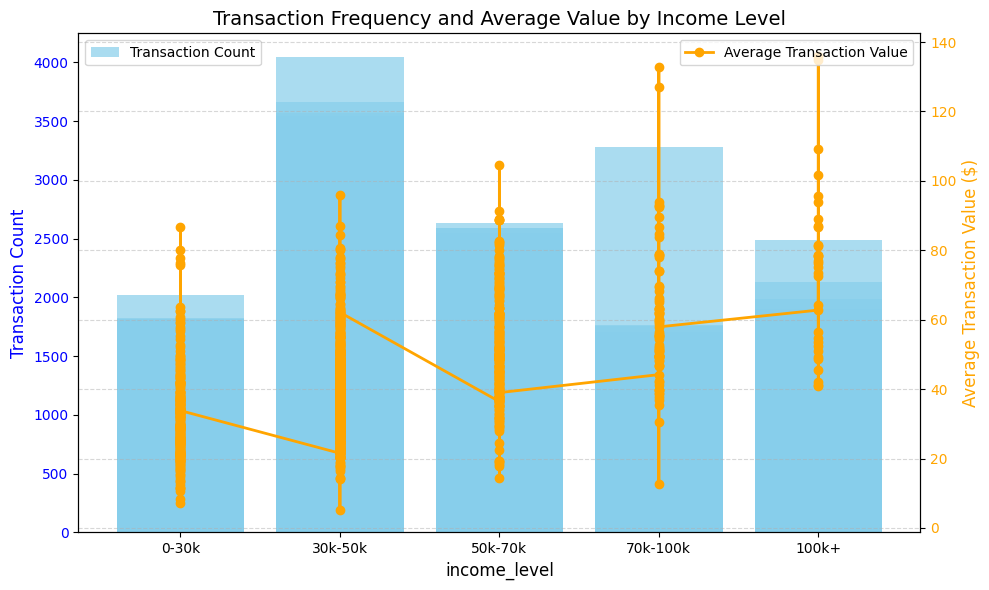

In [9]:

# Assuming income_analysis DataFrame is already created and contains 'income_level', 'transaction_count', and 'average_transaction_value'

# Create the figure and axis for plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for transaction count (spending frequency)
ax1.bar(income_analysis['income_level'], income_analysis['transaction_count'], 
        color='skyblue', label='Transaction Count', alpha=0.7)

ax1.set_xlabel('income_level', fontsize=12)
ax1.set_ylabel('Transaction Count', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add a second y-axis for average transaction value
ax2 = ax1.twinx()
ax2.plot(income_analysis['income_level'], income_analysis['average_transaction_value'], 
         color='orange', marker='o', label='Average Transaction Value', linewidth=2)
ax2.set_ylabel('Average Transaction Value ($)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legend
plt.title('Transaction Frequency and Average Value by Income Level', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show gridlines and plot
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Display the plot
plt.show()


### Do users with higher income levels make more frequent or higher-value transactions?

### **Summary**: Higher-income users prioritize higher-value transactions over frequency, while mid-income users transact more frequently but at lower values.


In [12]:
# Ensure 'merged_data' has both 'num_credit_cards' and 'amount' columns
# We assume merged_data already includes 'num_credit_cards' and 'amount' from previous steps

# Step 1: Aggregate total yearly spending for each user (assuming a 'date' column exists)
merged_data['date'] = pd.to_datetime(merged_data['date'])  # Convert date to datetime if not already
merged_data['year'] = merged_data['date'].dt.year  # Extract the year from the date

# Calculate total spending per user per year
total_spending_per_user = merged_data.groupby(['client_id', 'year']).agg({
    'amount': 'sum'  # Sum of transaction amounts for each user each year
}).reset_index()

# Step 2: Merge with users_data to include the number of credit cards for each user
total_spending_per_user = total_spending_per_user.merge(
    users_data[['client_id', 'num_credit_cards']], 
    on='client_id',
    how='left'
)

# Step 3: Calculate correlation between number of credit cards and total yearly spending
correlation = total_spending_per_user[['num_credit_cards', 'amount']].corr().iloc[0, 1]

# Display the correlation result
print(f"Correlation between the number of credit cards and total yearly spending: {correlation:.2f}")

Correlation between the number of credit cards and total yearly spending: 0.09


### Is there a correlation between the number of credit cards and total yearly spending?

### Correlation between the number of credit cards and total yearly spending: 0.09

In [13]:
age_spending_analysis = merged_data.groupby('current_age').agg({
    'id_x': 'count',  # Transaction frequency
    'amount': 'mean'  # Average transaction value
}).rename(columns={'id_x': 'transaction_count', 'amount': 'average_transaction_value'}).reset_index()


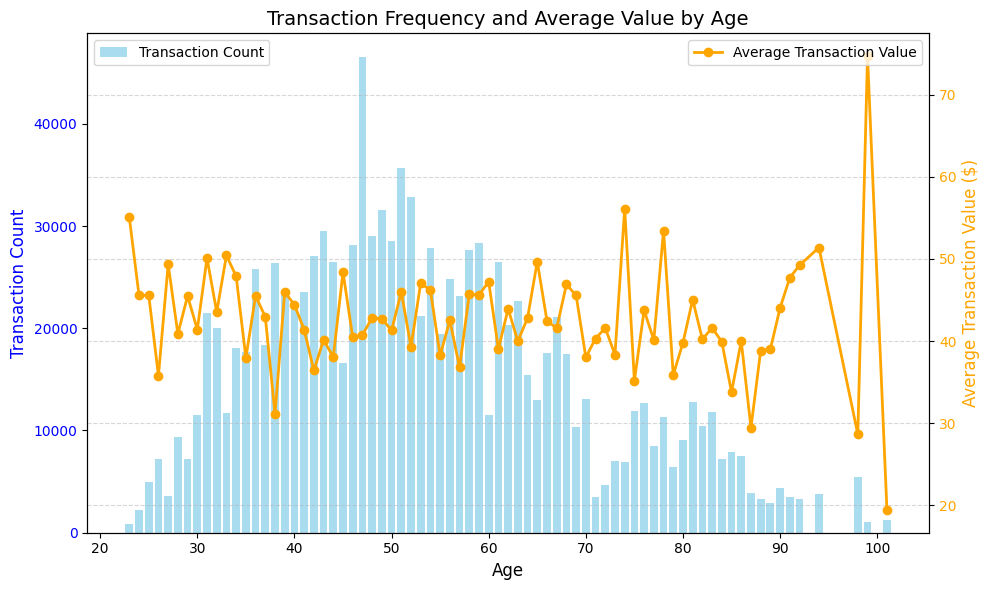

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for transaction count (spending frequency)
ax1.bar(age_spending_analysis['current_age'], age_spending_analysis['transaction_count'], 
        color='skyblue', label='Transaction Count', alpha=0.7)
ax1.set_xlabel('Age', fontsize=12)
ax1.set_ylabel('Transaction Count', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add a second y-axis for average transaction value
ax2 = ax1.twinx()
ax2.plot(age_spending_analysis['current_age'], age_spending_analysis['average_transaction_value'], 
         color='orange', marker='o', label='Average Transaction Value', linewidth=2)
ax2.set_ylabel('Average Transaction Value ($)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legend
plt.title('Transaction Frequency and Average Value by Age', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show gridlines and plot
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Display the plot
plt.show()

### How do spending habits vary across age groups? Age and Spending Patterns

### age groups [30 ~60 ] have higher transaction frequencies but lower transaction values, or that older age groups make fewer transactions but spend more per transaction.

## Step2 Feature Selection : Feature Engineering : Correlation Analysis

Number of outliers in amount: 93331
Number of outliers in current_age: 7709
Number of outliers in retirement_age: 120386
Number of outliers in per_capita_income: 68207
Number of outliers in yearly_income: 64039
Number of outliers in credit_score: 37980
Number of outliers in total_debt: 26376
Number of outliers in debt_to_income: 588
Number of outliers in num_credit_cards: 2536


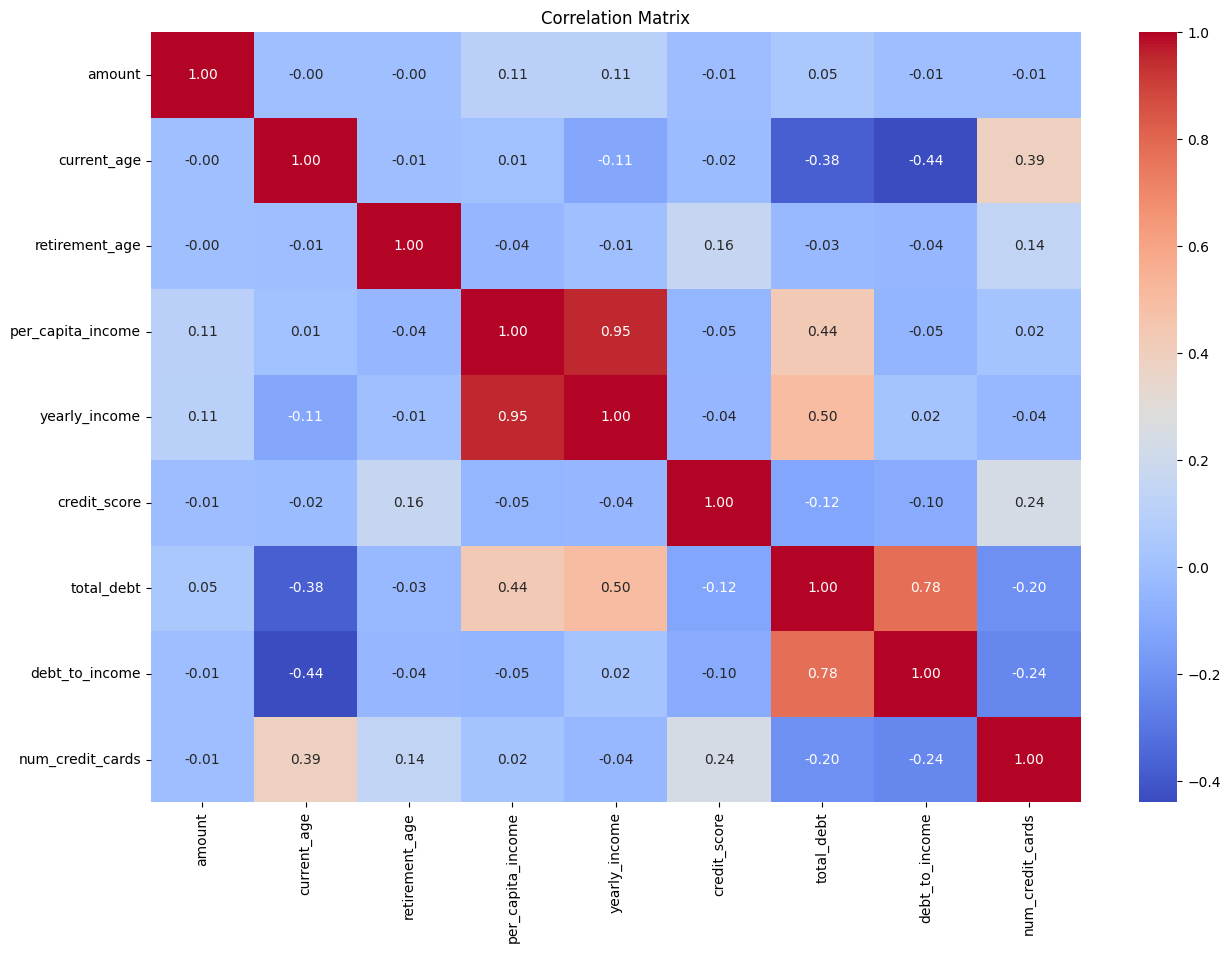

In [18]:
merged_data['debt_to_income'] = merged_data['total_debt'] / merged_data['yearly_income']
numerical_columns = ['amount', 'current_age', 'retirement_age', 'per_capita_income', 'yearly_income', 'credit_score', 'total_debt', 'debt_to_income', 'num_credit_cards'] 
# Handling Outliers
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Detect and print outliers for financial columns
for col in numerical_columns:
    outliers = detect_outliers_iqr(merged_data, col)
    print(f'Number of outliers in {col}: {len(outliers)}')

# Correlation Analysis
correlation_matrix = merged_data[numerical_columns].corr()

# Heatmap of correlations
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Features for Customer Segmentation:
- **Per Capita Income (`per_capita_income`)**: Strongly correlated with `yearly_income`
    - If your segmentation aims to capture individual financial capacity, use per_capita_income.
    - If the focus is on overall household or total income, use yearly_income.
- **Yearly Income (`yearly_income`)**: Indicates financial capability, useful for segmentation.
- **Transaction Amount (`amount`)**: Captures spending patterns and purchasing power.
- **Number of Credit Cards (`num_credit_cards`)**: Differentiates users based on credit habits.
- **Credit Score (`credit_score`)**: Reflects financial reliability and trustworthiness.
- **Total Debt (`total_debt`)**: Relevant for understanding customer liabilities.
- **Debt-to-Income Ratio (`debt_to_income`)**: Adds insights into financial risk.
- **Total Debt (`total_debt`) is strongly corelated with Debt-to-Income Ratio (`debt_to_income`)
    - If your segmentation focuses on the absolute financial burden, total_debt is more relevant.
    - If you want to capture a normalized view of debt relative to income, debt_to_income is better.

### Features for Anomaly Detection:
- **Transaction Amount (`amount`)**: Outliers in spending patterns can indicate anomalies.
- **Debt-to-Income Ratio (`debt_to_income`)**: High values may flag financial distress.
- **Number of Credit Cards (`num_credit_cards`)**: Excessively high numbers could indicate unusual credit usage.
- **Total Debt (`total_debt`)**: Excessive debt levels might be anomalies.
- **Credit Score (`credit_score`)**: Extremely low or high scores could signal unusual cases.


## Model Building
### Step 3: Normalization: Standardize or normalize the data for clustering.
### Step 4: Clustering: Apply K-Means or GMM to segment customers.
### Step 5: Visualization: Optionally, visualize the clusters.

#### Customer Segmentation Model1 : based on total_spending, avg_spending, transaction_count, debt_to_income

Features DataFrame Shape: (1141312, 4)
   total_spending  avg_spending  transaction_count  debt_to_income
0        19236.71     40.244163                478        1.231780
1        61203.37     48.690032               1257        1.060698
2        78715.52     24.013276               3278        0.026335
3        55148.10     33.201746               1661        0.000000
4        78715.52     24.013276               3278        0.026335
Cluster Assigned: [2 0 1]


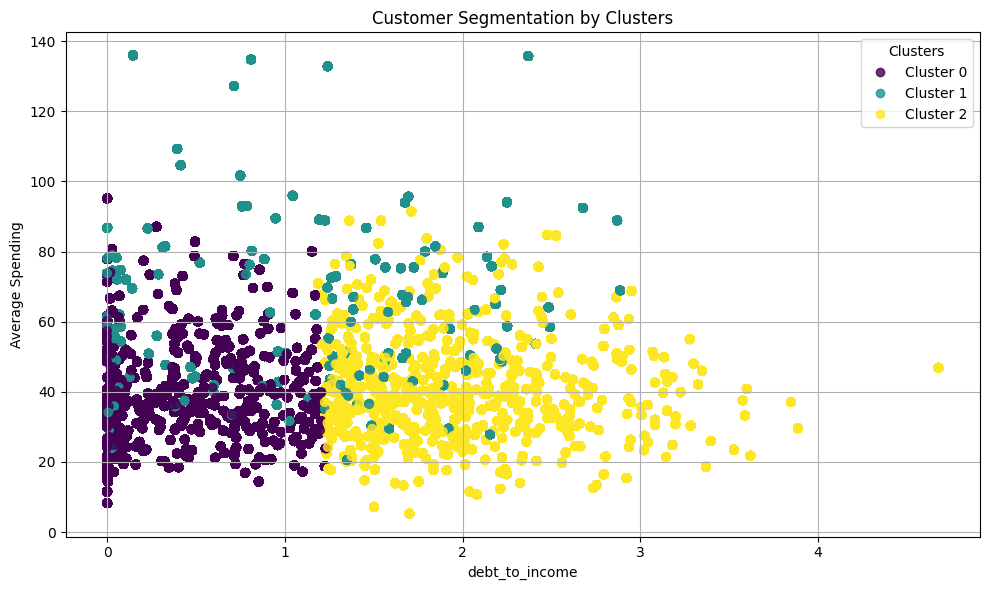

In [16]:
# Feature Engineering (Example Features)
merged_data['total_spending'] = merged_data.groupby('client_id')['amount'].transform('sum')
merged_data['avg_spending'] = merged_data.groupby('client_id')['amount'].transform('mean')
merged_data['transaction_count'] = merged_data.groupby('client_id')['amount'].transform('count')
merged_data['debt_to_income'] = merged_data['total_debt'] / merged_data['yearly_income']

# Select Relevant Features for Clustering
features = merged_data[['total_spending', 'avg_spending', 'transaction_count', 'debt_to_income']].dropna()

# Debugging: Check if features are valid
print("Features DataFrame Shape:", features.shape)
print(features.head())

# Normalize Data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
merged_data['cluster'] = kmeans.fit_predict(scaled_features)

# Debugging: Ensure 'cluster' column exists
print("Cluster Assigned:", merged_data['cluster'].unique())


# Scatterplot with Legend for Clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    features['debt_to_income'], 
    features['avg_spending'], 
    c=merged_data['cluster'], 
    cmap='viridis', 
    alpha=0.8
)

# Adding Legend for Clusters
handles, labels = scatter.legend_elements()

# Preprocess the labels outside of the f-string
processed_labels = []
for label in labels:
    match = re.search(r'\d+', label)
    if match:
        processed_labels.append(f"Cluster {int(match.group())}")
    else:
        processed_labels.append("Unknown")

# Adding the legend
plt.legend(
    handles,
    processed_labels,
    title="Clusters",
    loc="upper right"
)

# Labels and Title
plt.xlabel('debt_to_income')
plt.ylabel('Average Spending')
plt.title('Customer Segmentation by Clusters')
plt.grid(True)
plt.tight_layout()

plt.show()



#### Customer Segmentation Model2 : based on 'current_age', 'yearly_income', 'transaction_count', 'avg_transaction_value','credit_score', 'debt_to_income'

C:\Users\Admin\AppData\Local\Temp\ipykernel_12368\2689459290.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(features.mean(), inplace=True)


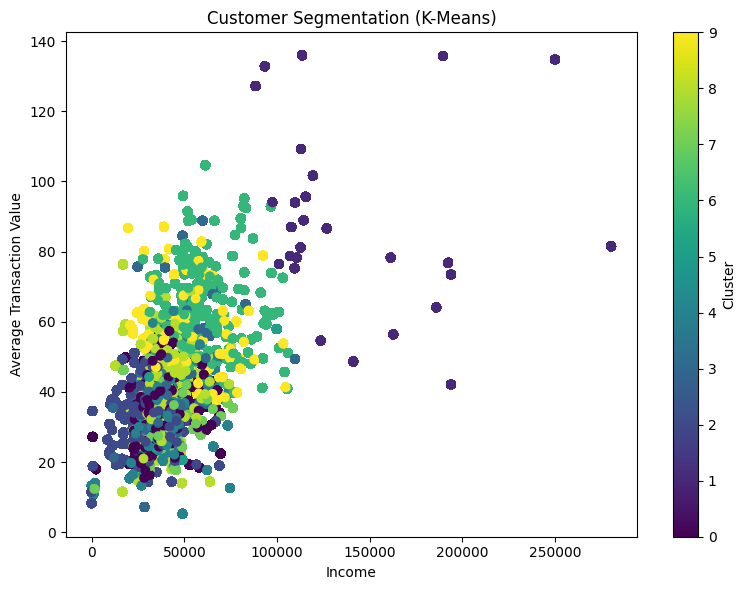

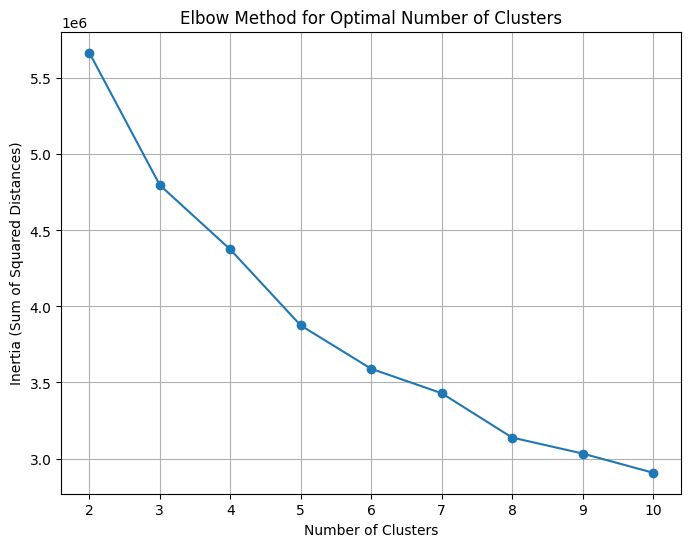

Cluster Centers:
[[-0.66765973 -0.29617959 -0.40762645 -0.49930381  0.48757506 -0.67981983]
 [ 0.17677355  4.00322875  0.09389702  2.34137744 -0.15033658 -0.19150319]
 [ 1.46944129 -0.67605727 -0.13611848 -0.55647856  0.23860954 -1.05910309]
 [ 0.2398546  -0.08874934 -0.13526791 -0.02831886 -2.12675395  0.2776142 ]
 [-0.13640527 -0.27661964 -0.29271433 -0.50946779  0.9522857   1.11111267]
 [ 0.30018487 -0.01487782  3.3523601  -0.35209737  0.00776556 -0.70534364]
 [-0.6379935   0.69714852 -0.14173341  1.25571553  0.15536011  0.11705256]
 [-0.36877746 -0.13936825  1.19521561 -0.57427402 -0.03208731  0.52205179]
 [-0.543396   -0.26900038 -0.54303048 -0.1693757  -0.5025222   0.8245243 ]
 [ 1.12169721  0.32747364 -0.15547731  0.73919862  0.09907415 -1.02551955]]
   client_id  yearly_income  transaction_count  avg_transaction_value  cluster
0        496        36319.0                478              40.244163        0
1       1129        34449.0               1257              48.690032     

In [17]:
# Load the merged dataset (after merging transaction and user data)
# Assuming 'merged_df' is the combined data
# Example features: 'income', 'transaction_count', 'avg_transaction_value'
silhouette_scores = []

merged_data['avg_transaction_value'] = merged_data.groupby('client_id')['amount'].transform('mean')
merged_data['transaction_count'] = merged_data.groupby('client_id')['amount'].transform('count')
#merged_data['debt_to_income'] = merged_data['total_debt'] / merged_data['yearly_income']

# Select the features for segmentation
features = merged_data[['current_age', 'yearly_income', 'transaction_count', 'avg_transaction_value','credit_score', 'debt_to_income']]

# Handle missing values by filling them with the mean or drop them (optional)
features.fillna(features.mean(), inplace=True)

# Normalize the data using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Elbow Method: Calculate inertia (sum of squared distances to centroids) for a range of cluster numbers
inertia = []
cluster_range = range(2, 11)  # Test cluster numbers from 1 to 10

# Try differencluster_rangembers of clusters (components)
for n_clusters in cluster_range:  # Check clusters from 2 to 10
    
    # Apply K-Means clustering (choose an appropriate number of clusters, e.g., 3)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    merged_data['cluster'] = kmeans.fit_predict(scaled_features)
     
    # Silhouette Score (use only for a 2D/3D clustering analysis)
    #silhouette_avg = silhouette_score(scaled_features, kmeans.fit_predict(scaled_features))
    #silhouette_scores.append(silhouette_avg)

    inertia.append(kmeans.inertia_)
    
# Optionally: Visualize the clusters in 2D (for simplicity, use first two features)
plt.figure(figsize=(8,6))
plt.scatter(merged_data['yearly_income'], merged_data['avg_transaction_value'], c=merged_data['cluster'], cmap='viridis')
plt.title('Customer Segmentation (K-Means)')
plt.xlabel('Income')
plt.ylabel('Average Transaction Value')
plt.colorbar(label='Cluster')

'''
# Plot the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, label="Silhouette Score", marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.legend()
'''
plt.tight_layout()
plt.show()

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

# Display the cluster centers (mean values of each cluster)
print('Cluster Centers:')
print(kmeans.cluster_centers_)

# Optional: Show customer segmentation with the assigned clusters
print(merged_data[['client_id', 'yearly_income', 'transaction_count', 'avg_transaction_value', 'cluster']].head())

C:\Users\Admin\AppData\Local\Temp\ipykernel_12368\3067672375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(features.mean(), inplace=True)


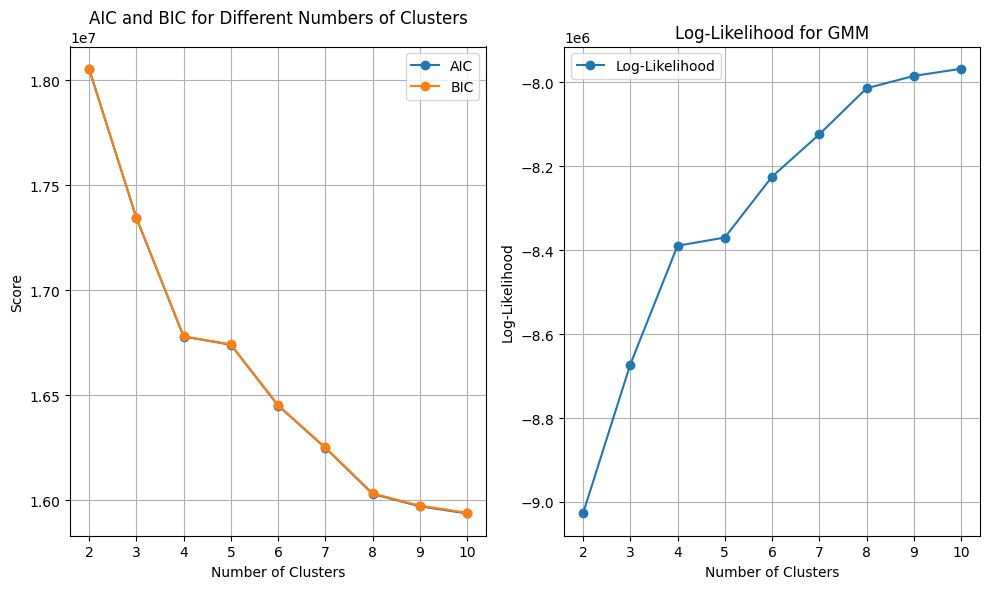

Best number of clusters based on AIC/BIC: 10


In [18]:

# Load and clean data (assumed merged_df is available)
features = merged_data[['current_age','yearly_income', 'transaction_count', 'avg_transaction_value','credit_score', 'debt_to_income']]

# Handle missing values and normalize the data
features.fillna(features.mean(), inplace=True)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# List to store the results of AIC, BIC, and silhouette score for each number of clusters
aic_scores = []
bic_scores = []
silhouette_scores = []

#log-likelihood values for different numbers of clusters
log_likelihood = []

cluster_range = range(2, 11)  # Test cluster numbers from 1 to 10

# Try different numbers of clusters (components)
for n_clusters in cluster_range:  # Check clusters from 2 to 10
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(scaled_features)
    
    # AIC and BIC scores
    aic_scores.append(gmm.aic(scaled_features))
    bic_scores.append(gmm.bic(scaled_features))

    log_likelihood.append(gmm.score(scaled_features) * len(scaled_features))  # log-likelihood

    '''
    # Silhouette Score (use only for a 2D/3D clustering analysis)
    if n_clusters > 1:  # Silhouette score is not defined for 1 cluster
        silhouette_avg = silhouette_score(scaled_features, gmm.predict(scaled_features))
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(None)
    '''
# Plot the AIC and BIC to determine the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), aic_scores, label="AIC", marker='o')
plt.plot(range(2, 11), bic_scores, label="BIC", marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.grid(True)
plt.title("AIC and BIC for Different Numbers of Clusters")
plt.legend()

'''
# Plot the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, label="Silhouette Score", marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.legend()
'''

# Log-likelihood plot
plt.subplot(1, 2, 2)
plt.plot(cluster_range, log_likelihood, label='Log-Likelihood', marker='o')
plt.title('Log-Likelihood for GMM')
plt.xlabel('Number of Clusters')
plt.ylabel('Log-Likelihood')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print the best number of clusters based on each criterion
best_aic_bic = min(zip(aic_scores, bic_scores, range(2, 11)))
#best_silhouette = max(silhouette_scores)

print(f"Best number of clusters based on AIC/BIC: {best_aic_bic[2]}")
#print(f"Best number of clusters based on Silhouette Score: {silhouette_scores.index(best_silhouette) + 2}")

## Customer segmentation evaluations


1. **Elbow Method for Optimal Number of Clusters**:  4 or 5 clusters
2. **AIC and BIC for Different Numbers of Clusters**:The rate of decrease slows after around 4 clusters, indicating this could be the optimal number for a balance between model complexity and fit.
3. **Log-Likelihood for GMM**: Log-likelihood steadily improves as the number of clusters increases, but the rate of improvement slows after around 4 or 5 clusters, suggesting these values are optimal for GMM.

## Conclusion: Optimal Number of Clusters
- Based on all three methods (Elbow Method, AIC/BIC, and Log-Likelihood), 4 clusters is the most likely optimal choice. This strikes a balance between simplicity, interpretability, and capturing the underlying data structure.

## Customer egmentation Model : GMM with num of clusters=4

C:\Users\Admin\AppData\Local\Temp\ipykernel_12368\2399667134.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(features.mean(), inplace=True)


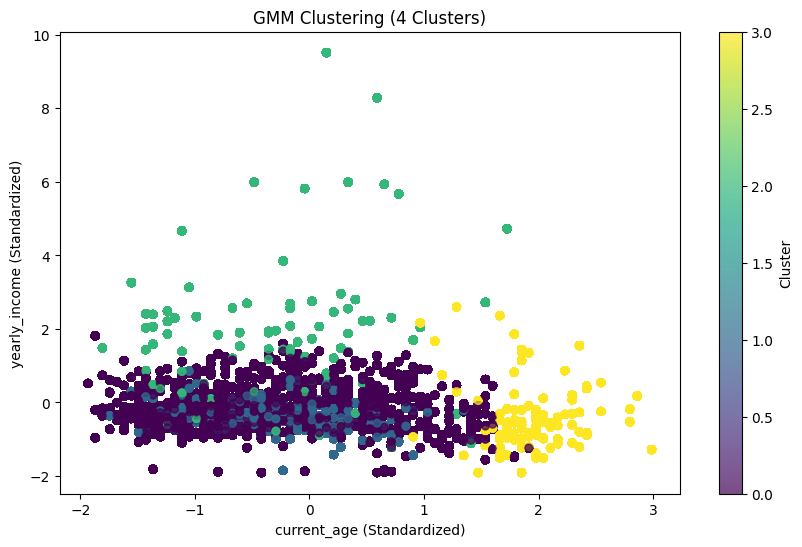

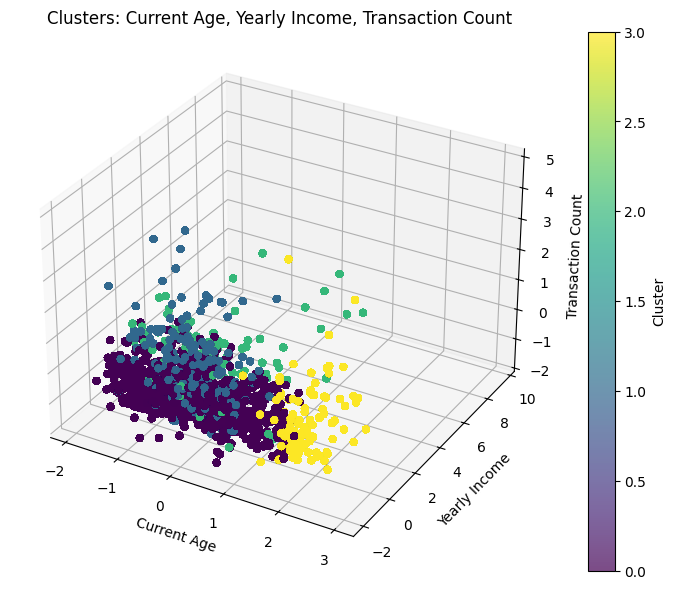

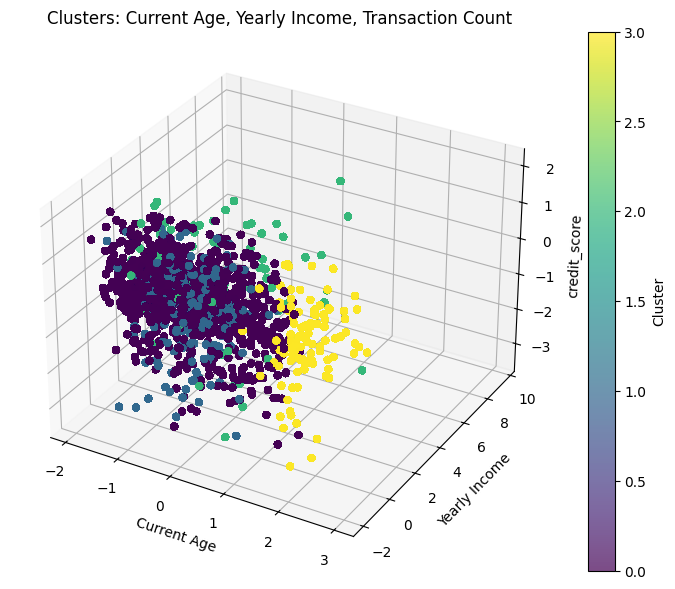

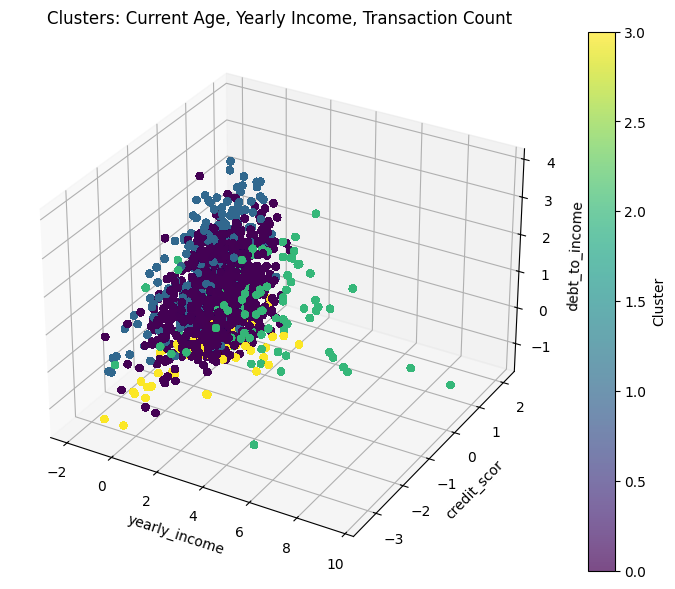

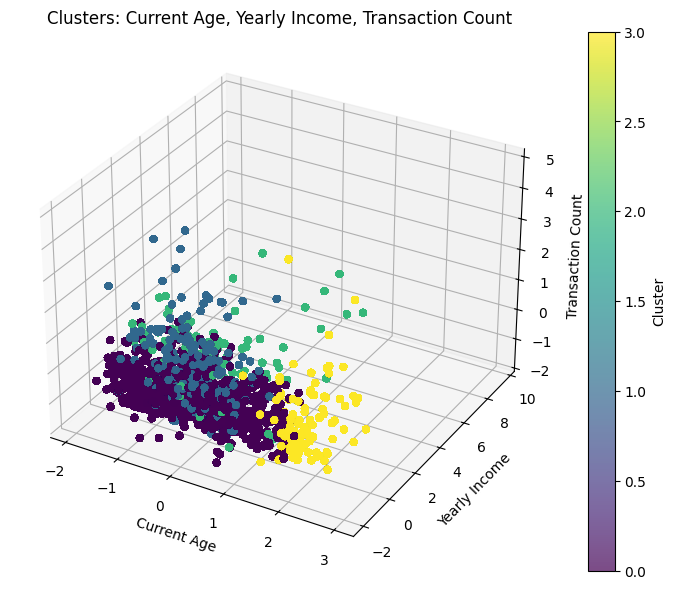

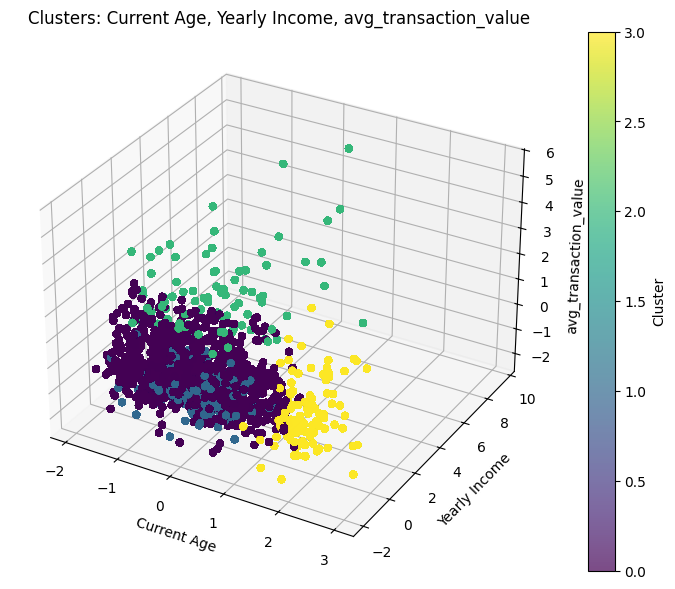

Cluster Centers (Original Scale):
Cluster 0: [5.06697674e+01 4.39597954e+04 9.31919043e+02 4.14192021e+01
 7.18028913e+02 1.18910600e+00]
Cluster 1: [5.04803333e+01 3.91206714e+04 1.65855799e+03 3.35138773e+01
 7.05696601e+02 1.82834283e+00]
Cluster 2: [4.86517806e+01 8.55571295e+04 1.29244949e+03 6.83353134e+01
 7.05683957e+02 1.32732377e+00]
Cluster 3: [8.42209220e+01 4.02205061e+04 1.33717549e+03 4.12541640e+01
 7.18585985e+02 4.38691423e-02]


In [25]:

# Assuming 'merged_data' is already loaded and contains the necessary features
# Select relevant features for clustering
features = merged_data[['current_age','yearly_income', 'transaction_count', 'avg_transaction_value','credit_score', 'debt_to_income']]

#'total_debt'
# Handle missing values (if any)
features.fillna(features.mean(), inplace=True)

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Fit GMM with 5 clusters
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(scaled_features)

# Predict cluster assignments
clusters = gmm.predict(scaled_features)

# Add the cluster labels to the original data
merged_data['Cluster'] = clusters

# Visualize the clusters (using the first two features for simplicity)
plt.figure(figsize=(10, 6))
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=clusters, cmap='viridis', s=30, alpha=0.7)
plt.title('GMM Clustering (4 Clusters)')
plt.xlabel('current_age (Standardized)')
plt.ylabel('yearly_income (Standardized)')
plt.colorbar(label='Cluster')
plt.show()

# 3D Scatterplot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(scaled_features[:, 0], scaled_features[:, 1], 
                scaled_features[:, 2], c=clusters, cmap='viridis', alpha=0.7)

ax.set_title('Clusters: Current Age, Yearly Income, Transaction Count')
ax.set_xlabel('Current Age')
ax.set_ylabel('Yearly Income')
ax.set_zlabel('Transaction Count')
plt.colorbar(sc, label='Cluster')
plt.show()

#features = merged_data[['current_age','yearly_income', 'transaction_count', 'avg_transaction_value','credit_score', 'debt_to_income']]

# 3D Scatterplot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(scaled_features[:, 0], scaled_features[:, 1], 
                scaled_features[:, 4], c=clusters, cmap='viridis', alpha=0.7)

ax.set_title('Clusters: Current Age, Yearly Income, Transaction Count')
ax.set_xlabel('Current Age')
ax.set_ylabel('Yearly Income')
ax.set_zlabel('credit_score')
plt.colorbar(sc, label='Cluster')
plt.show()

# 3D Scatterplot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(scaled_features[:, 1], scaled_features[:, 4], 
                scaled_features[:, 5], c=clusters, cmap='viridis', alpha=0.7)

ax.set_title('Clusters: Current Age, Yearly Income, Transaction Count')
ax.set_xlabel('yearly_income')
ax.set_ylabel('credit_scor')
ax.set_zlabel('debt_to_income')
plt.colorbar(sc, label='Cluster')
plt.show()

# 3D Scatterplot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(scaled_features[:, 0], scaled_features[:, 1], 
                scaled_features[:, 2], c=clusters, cmap='viridis', alpha=0.7)

ax.set_title('Clusters: Current Age, Yearly Income, Transaction Count')
ax.set_xlabel('Current Age')
ax.set_ylabel('Yearly Income')
ax.set_zlabel('Transaction Count')
plt.colorbar(sc, label='Cluster')
plt.show()
# 3D Scatterplot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(scaled_features[:, 0], scaled_features[:, 1], 
                scaled_features[:, 3], c=clusters, cmap='viridis', alpha=0.7)

ax.set_title('Clusters: Current Age, Yearly Income, avg_transaction_value')
ax.set_xlabel('Current Age')
ax.set_ylabel('Yearly Income')
ax.set_zlabel('avg_transaction_value')
plt.colorbar(sc, label='Cluster')
plt.show()

# Print cluster means
cluster_centers = scaler.inverse_transform(gmm.means_)
print("Cluster Centers (Original Scale):")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}: {center}")


In [26]:
# Assuming 'merged_data' is already loaded and contains the necessary features
# Select relevant features for clustering
#features = merged_data[['current_age','yearly_income', 'transaction_count', 'avg_transaction_value','credit_score', 'debt_to_income','total_debt']]
#features = merged_data[['yearly_income', 'transaction_count', 'total_debt']]
features = merged_data[['current_age','yearly_income', 'transaction_count', 'avg_transaction_value','credit_score', 'total_debt']]
#
#'total_debt'
# Handle missing values (if any)
features.fillna(features.mean(), inplace=True)

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Fit GMM with 5 clusters
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(scaled_features)

# Predict cluster assignments
clusters = gmm.predict(scaled_features)

# Add the cluster labels to the original data
merged_data['Cluster'] = clusters


C:\Users\Admin\AppData\Local\Temp\ipykernel_12368\3892534950.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(features.mean(), inplace=True)


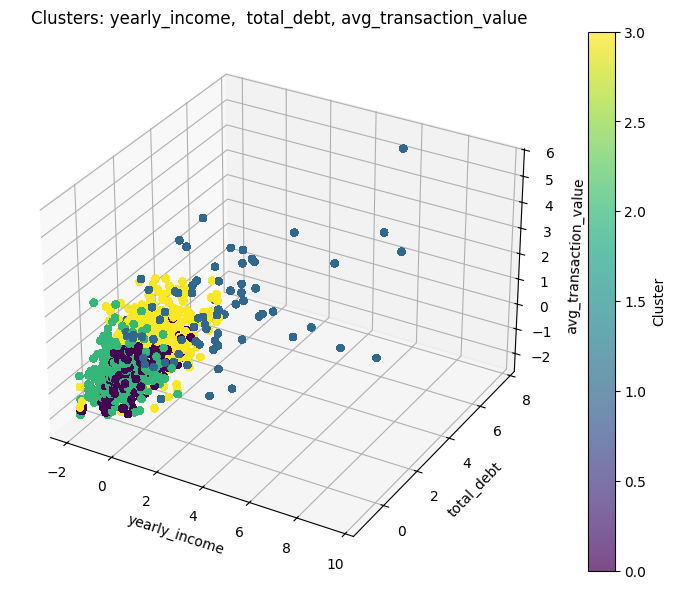

In [27]:
# 3D Scatterplot

#features = merged_data[['current_age','yearly_income', 'transaction_count', 'avg_transaction_value','credit_score', 'total_debt']]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(scaled_features[:, 1], scaled_features[:, 5], 
                scaled_features[:, 3], c=clusters, cmap='viridis', alpha=0.7)

ax.set_title('Clusters: yearly_income,  total_debt, avg_transaction_value' )
ax.set_xlabel('yearly_income')
ax.set_ylabel('total_debt')
ax.set_zlabel('avg_transaction_value')
plt.colorbar(sc, label='Cluster')
plt.show()

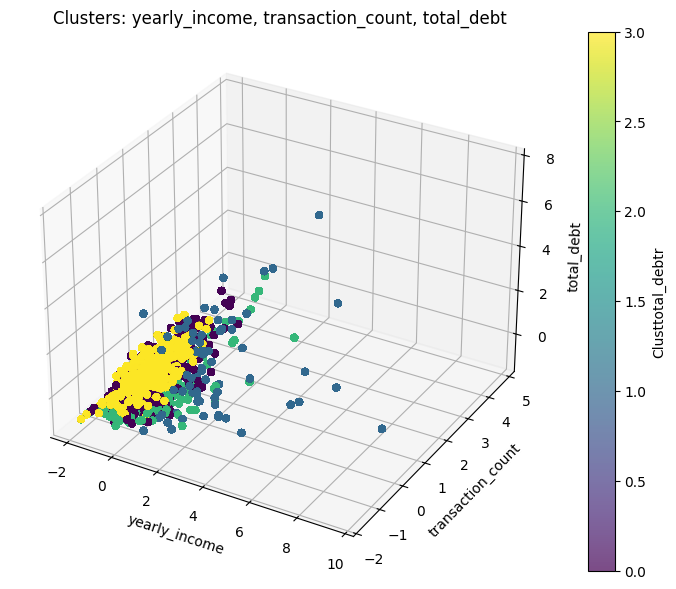

In [28]:
# 3D Scatterplot

#features = merged_data[['current_age','yearly_income', 'transaction_count', 'avg_transaction_value','credit_score', 'total_debt']]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(scaled_features[:, 1], scaled_features[:, 2], 
                scaled_features[:, 5], c=clusters, cmap='viridis', alpha=0.7)


ax.set_title('Clusters: yearly_income, transaction_count, total_debt')
ax.set_xlabel('yearly_income')
ax.set_ylabel('transaction_count')
ax.set_zlabel('total_debt')
plt.colorbar(sc, label='Clusttotal_debtr')
plt.show()

### Cluster Insights:

- **Cluster 0 (purple):**  
  Concentrated at the lower income, fewer transactions, and lower debt levels. Likely represents low-income, low-activity customers..

- **Cluster 1 :**
  Positioned slightly higher in income and transactions with moderate debt levels. Represents average earners with mid-level activity..

- **Cluster 2 :**  
  Covers higher-income individuals with moderate transaction activity and higher debt levels. Likely represents financially active customers with significant obligations.

- **Cluster 3 :**  
  Likely represents entities with extremely high income, debt, or transaction value (outliers).Scattered across high-income and high-transaction regions, with the highest debt levels. Represents affluent users who are highly engaged financially but carry substantial debt.

## Insights:
- **Low-income, low-debt users  Cluster 0 :** A high-income, high debt and high avg transcation value cluster might represent debt-heavy users.
- **High-debt users Cluster 3 :**   might be key for focused risk management or credit offerings.
-  **Active customers Cluster 1 and Cluster 2:** but cater to different financial behaviors and strategies:
    - Cluster 1 for consistency and retention strategies. Moderately active and stable. A reliable customer base that likely drives consistent revenue.
    - Cluster 2 for upselling, credit offerings, andHighly active but slightly riskier. They are profitable but need monitoring for debt exposure.ancial planning assistance. 


## Cluster 3 : A high-income, low transaction count, high debt cluster, represents debt-heavy users.
## Cluster 2:  high transaction count, high avg transaction value, low debt cluster might represent high-spending customers.